## **Deep Learning Made Easy**

----

Author:  <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>.

<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

<br>

This is a notebook showing how to use transfer learning (TL) within a supervised context. The TL technique we use here is fine-tuning the deep convolutional neural network (CNN). We considered six pretrained models: ResNet-18, ResNet-34, DenseNet-121, DenseNet-161, GoogLeNet, and Inception-v3.  

In [ ]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change to "root" directory
%cd /content/drive/My Drive/Colab Notebooks/pyTorch/dlme
%ls

/content/drive/My Drive/Colab Notebooks/pyTorch/dlme
 B16_DCGAN.ipynb
'Copy of PyTorch CIFAR-10_Valdivino SantiagoV2.ipynb'
'Copy of TOrC_TL_adapted.ipynb'
 dcgan_faces_tutorialOriginal.ipynb
 densenetmodified.py
 imagenettetvt320/
 imagenettetvt320.zip
 out/
 phasesdnn.py
 __pycache__/
'PyTorch CIFAR-10_Valdivino Santiago.ipynb'
'PyTorch CIFAR-10_Valdivino Santiago_Profiler.ipynb'
'PyTorch CIFAR-10_Valdivino SantiagoV2.ipynb'
 pytorch-deep-explainer-mnist-example.ipynb
 PyTorch_DenseNet.ipynb
 PyTorch_Inception_TL.ipynb
'PyTorch MNIST_Valdivino Santiago.ipynb'
'PyTorch MNIST_Valdivino Santiago_Profiler.ipynb'
'PyTorch MNIST_Valdivino SantiagoV2.ipynb'
 PyTorch_VGG_ResNet_ResNetonly.ipynb
 resnetmodified.py
 Ricardo_DL_UNet_CropExample.ipynb
 user_options.txt
 utilsdnn.py
 utilsio.py
 utilsmetrics.py
 vggmodified.py


## **Create directories and unzip the datasets**
----

Create the following directories under the "root" directory:



1.   ```imagenettetvt320```. It will contain the <a href="https://github.com/fastai/imagenette">imagenette320 px</a> datasets. However, we split the original validation dataset into two: validation with 1/3 of the images of the original validation set, and 2/3 of the images compose the test dataset; 
2.   ```out```. It is to store the best model during training and other relevant outputs.

<br>

After that, run the command below only once to unzip all datasets (training, validation, test). It is assumed that the .zip file (imagenettetvt320.zip) has already been uploaded to the "root" Google Drive's directory.



In [ ]:
#!unzip "/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320.zip" -d "/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/imagenettetvt320"


## **Torchvision models**
----

Here, we are using the ```torchvision.models``` subpackage where the networks are already defined and we can reuse the knowledge of such pretrained models. 

In [ ]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os
import time
import torchvision
from torchvision import datasets, transforms, models # models: added for TL
from prettytable import PrettyTable
from torch.autograd import Variable
plt.ion()   # Interactive mode

In [ ]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

In [ ]:
# Custom dataset that includes image file paths. Extends 
# torchvision.datasets.ImageFolder
class FileNames(datasets.ImageFolder):
    
    # Override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # This is what ImageFolder normally returns 
        original_tuple = super(FileNames, self).__getitem__(index)
        # The image file path
        path = self.imgs[index][0]
        # Make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

## **Define important variables**
----

Here, we define the classes and also some hyper-parameters.

In [ ]:
# The directory of the datasets
data_dir = 'imagenettetvt320'

# All relevant outputs are here
output_dir = '/content/drive/My Drive/Colab Notebooks/pyTorch/dlme/out' 

# The number of classes
num_classes = 10

# Variables related to the selected CNN
indic = '' # Indicator of the selected CNN

# Images will be cropped to 224 x 224.
# Exception is Inception-v3: 299 x 299.
hei_wid = 224 

# Hyper-parameters
num_epochs = 10 # Number of epochs
batch_size = 4 # The size of input data took for one iteration
learning_rate = 0.001 # Learning rate
moment = 0.9 # Momentum

## **Select the CNN and load data**
----

Select the CNN and load data. All images are cropped below to 224 x 224 (variable ```hei_wid```). The only exception is Inception-v3 where the cropping should be: 299 x 299. Moreover, note that dynamic data augmentation and 
normalisation are used for the training dataset only. For the validation and test datasets, only normalisation.







In [ ]:
print("Select the CNN: ")
print("Press '1' for ResNet-18.")
print("Press '2' for ResNet-34.")
print("Press '3' for DenseNet-121.")
print("Press '4' for DenseNet-161.")
print("Press '5' for GoogLeNet.")
print("Press '6' for Inception-v3.")
opt = input("Enter your choice:")
if opt =='1':
  print("You selected ResNet-18!")
  indic = 'ResNet-18'
elif opt =='2':
  print("You selected ResNet-34!")
  indic = 'ResNet-34' 		
elif opt =='3':
  print("You selected DenseNet-121!")
  indic = 'DenseNet-121'
elif opt =='4':
  print("You selected DenseNet-161!")
  indic = 'DenseNet-161'
elif opt =='5':
  print("You selected GoogLeNet!")
  indic = 'GoogLeNet'
elif opt =='6':
  hei_wid = 299 # Changing cropping size
  print("You selected Inception-v3!")
  indic = 'Inception-v3'
else:
  print("Invalid Option!") 

Select the CNN: 
Press '1' for ResNet-18.
Press '2' for ResNet-34.
Press '3' for DenseNet-121.
Press '4' for DenseNet-161.
Press '5' for GoogLeNet.
Press '6' for Inception-v3.
Enter your choice:6
You selected Inception-v3!


## **Note about ```transforms.Normalize```**
----

As the <a href="https://pytorch.org/vision/stable/models.html">PyTorch documentation</a>: "All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]." This explain the values in ```transforms.Normalize```.

In [ ]:
# File that contains the best model obtained during the training phase
best_model_full = output_dir+'/best_model_'+indic+'.pt' 

# Tranformations for each dataset. Note that dynamic data augmentation and
# normalisation are used for the training dataset only. For the validation
# and test datasets, only normalisation.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(hei_wid),
        transforms.RandomHorizontalFlip(),                         
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        
    'val': transforms.Compose([
        #transforms.Resize(256), 
        transforms.CenterCrop(hei_wid),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        #transforms.Resize(256),                        
        transforms.CenterCrop(hei_wid), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: FileNames(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Just checking the sizes
print('\nDataset sizes: ', dataset_sizes)
print('Dataloaders sizes: ', len(dataloaders))
class_names = image_datasets['train'].classes
class_namesv = image_datasets['val'].classes
class_namest = image_datasets['test'].classes
print('Training classes: ', class_names)
print('Training lengths: ', len(class_names))
print('Validation classes: ', class_namesv)
print('Validation lengths: ', len(class_namesv))
print('Test classes: ', class_namest)
print('Test lengths: ', len(class_namest))
print('Height x Width: {} x {}'.format(hei_wid,hei_wid))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Dataset sizes:  {'train': 9469, 'val': 1309, 'test': 2616}
Dataloaders sizes:  3
Training classes:  ['cassetePlayer', 'chainShaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']
Training lengths:  10
Validation classes:  ['cassetePlayer', 'chainSaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']
Validation lengths:  10
Test classes:  ['cassetePlayer', 'chainShaw', 'church', 'englishSpringer', 'frenchHorn', 'garbageTruck', 'gasPump', 'golfBall', 'parachute', 'tench']
Test lengths:  10
Height x Width: 299 x 299


One batch - training dataset: torch.Size([4, 3, 299, 299])

Each image of the batch:
Image: 0 - Input shape: torch.Size([3, 299, 299]) - Class: chainShaw
Image: 1 - Input shape: torch.Size([3, 299, 299]) - Class: church
Image: 2 - Input shape: torch.Size([3, 299, 299]) - Class: parachute
Image: 3 - Input shape: torch.Size([3, 299, 299]) - Class: church
The "image" itself:  tensor([[[ 2.1804,  2.1804,  2.1633,  ...,  0.9817,  0.9646,  0.9474],
         [ 2.1804,  2.1804,  2.1633,  ...,  0.9817,  0.9646,  0.9474],
         [ 2.1804,  2.1804,  2.1633,  ...,  0.9646,  0.9474,  0.9303],
         ...,
         [ 0.0569,  0.0227, -0.0116,  ..., -1.9124, -1.9467, -1.9638],
         [-0.0801, -0.0458, -0.0116,  ..., -2.0323, -1.9295, -1.8782],
         [-0.1657, -0.0972, -0.0116,  ..., -2.1179, -1.9295, -1.8097]],

        [[ 2.2885,  2.2885,  2.2710,  ...,  0.9230,  0.9055,  0.8880],
         [ 2.2885,  2.2885,  2.2710,  ...,  0.9230,  0.9055,  0.8880],
         [ 2.2885,  2.2885,  2.2710,  ..

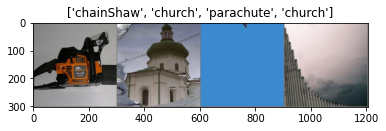

In [ ]:
# Just visualising some images
def visualise_images(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Get a batch: training dataset
dataiter = iter(dataloaders['train'])
images, labels, paths = dataiter.next()
print('One batch - training dataset:', images.shape)

print('\nEach image of the batch:')
for i in range(labels.shape[0]):
  print('Image: {} - Input shape: {} - Class: {}'.format(i, images[i].shape, image_datasets['train'].classes[labels[i]]))
  if i == (labels.shape[0]-1):
    print('The "image" itself: ', images[i])

# Show images
img_batch = torchvision.utils.make_grid(images)
visualise_images(img_batch, title=[class_names[x] for x in labels])

## **Instantiate the selected CNN**
----

Now, we instantiate the previous selected CNN.


In [ ]:
# Number of input features for the last layer (fully-connected)
num_ftrs = -1 
if opt =='1':
  net = models.resnet18(pretrained=True)
  num_ftrs = net.fc.in_features
  print('Input features - ResNet-18:', num_ftrs) 
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='2':
  net = models.resnet34(pretrained=True)
  num_ftrs = net.fc.in_features
  print('Input features - ResNet-34:', num_ftrs)
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='3':
  net = models.densenet121(pretrained=True)
  num_ftrs = net.classifier.in_features
  print('Input - features DenseNet-121:', num_ftrs)
  net.classifier = nn.Linear(num_ftrs, num_classes)
elif opt =='4':
  net = models.densenet161(pretrained=True)
  num_ftrs = net.classifier.in_features
  print('Input features - DenseNet-161:', num_ftrs)
  net.classifier = nn.Linear(num_ftrs, num_classes)
elif opt =='5':
  net = models.googlenet(pretrained=True, aux_logits=False)
  num_ftrs = net.fc.in_features
  print('Input features - GoogLeNet:', num_ftrs)
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='6':
  net = models.inception_v3(pretrained=True, aux_logits=False)
  num_ftrs = net.fc.in_features
  print('Input features - Inception-v3:', num_ftrs)
  net.fc = nn.Linear(num_ftrs, num_classes)
else:
  print("Invalid Option!")
     
net = net.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Input features - Inception-v3: 2048


## **Define loss function and optimiser**

----

The <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">CrossEntropyLoss</a> function combines LogSoftmax and NLLLoss in one single class. Optimiser is SGD, the learning rate and momentum have already been defined.

In [ ]:
# Cross-entropy Loss
loss_function = nn.CrossEntropyLoss()

# All parameters are being optimised
optimiser = optim.SGD(net.parameters(), lr=learning_rate, momentum=moment)

print('Checking trainable parameters: {}'.format(count_parameters(net)))

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|      Conv2d_1a_3x3.conv.weight       |    864     |
|       Conv2d_1a_3x3.bn.weight        |     32     |
|        Conv2d_1a_3x3.bn.bias         |     32     |
|      Conv2d_2a_3x3.conv.weight       |    9216    |
|       Conv2d_2a_3x3.bn.weight        |     32     |
|        Conv2d_2a_3x3.bn.bias         |     32     |
|      Conv2d_2b_3x3.conv.weight       |   18432    |
|       Conv2d_2b_3x3.bn.weight        |     64     |
|        Conv2d_2b_3x3.bn.bias         |     64     |
|      Conv2d_3b_1x1.conv.weight       |    5120    |
|       Conv2d_3b_1x1.bn.weight        |     80     |
|        Conv2d_3b_1x1.bn.bias         |     80     |
|      Conv2d_4a_3x3.conv.weight       |   138240   |
|       Conv2d_4a_3x3.bn.weight        |    192     |
|        Conv2d_4a_3x3.bn.bias         |    192     |
|    Mixed_5b.branch1x1.conv

## **Run the Training Phase**
----

Now, we can run the training phase. 



In [ ]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []
best_loss_validation = sys.float_info.max
best_epoch = sys.float_info.max
train_time_init = time.time()
#### Main training loop: Begin
for epoch in range(num_epochs):
  #### Each epoch has a training and validation phase: Begin
  for phase in ['train', 'val']:
    if phase == 'train':
      net.train() # Set model to training mode
    else:
      net.eval()  # Set model to evaluate mode
   
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data: Begin
    for images, labels, paths in dataloaders[phase]: 
      images = Variable(images).to(device) # Send to GPU
      labels = Variable(labels).to(device) # Send to GPU
    
      optimiser.zero_grad()
      with torch.set_grad_enabled(phase == 'train'):
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)
        
        # Backward + optimise only if in training phase. 
        if phase == 'train':
          loss.backward()
          optimiser.step()
    
      running_loss += loss.item() * images.size(0)
      running_corrects += torch.sum(preds == labels.data)
    # Iterate over data: End

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase] 
    print('Phase: {}, Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(
                 phase, epoch+1, num_epochs, epoch_loss, epoch_acc))
    
    if phase == 'train': # Training
      train_losses.append(epoch_loss)
      train_acc.append(epoch_acc) 
    else: # Validation
      val_losses.append(epoch_loss)
      val_acc.append(epoch_acc) 
      if (epoch_loss < best_loss_validation):
        best_loss_validation = epoch_loss
        best_epoch = epoch + 1
        if os.path.exists(best_model_full):
          os.remove(best_model_full)
          print('####### Validation loss: previous best model removed!!!!')
        else:
          print("####### Validation loss: there is no saved model yet!!!!")
        torch.save(net.state_dict(), best_model_full)
        print('####### Validation loss: new best model saved in Epoch: {} !!!!'.format(str(epoch + 1)))
  #### Each epoch has a training and validation phase: End
#### Main training loop: End
train_time_end = time.time() - train_time_init

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Phase: train, Epoch 1/10, Loss: 0.8028, Accuracy: 0.7608
Phase: val, Epoch 1/10, Loss: 0.3210, Accuracy: 0.9121
####### Validation loss: there is no saved model yet!!!!
####### Validation loss: new best model saved in Epoch: 1 !!!!
Phase: train, Epoch 2/10, Loss: 0.6565, Accuracy: 0.8040
Phase: val, Epoch 2/10, Loss: 0.1955, Accuracy: 0.9427
####### Validation loss: previous best model removed!!!!
####### Validation loss: new best model saved in Epoch: 2 !!!!
Phase: train, Epoch 3/10, Loss: 0.5967, Accuracy: 0.8196
Phase: val, Epoch 3/10, Loss: 0.2064, Accuracy: 0.9435
Phase: train, Epoch 4/10, Loss: 0.5303, Accuracy: 0.8423
Phase: val, Epoch 4/10, Loss: 0.2826, Accuracy: 0.9320
Phase: train, Epoch 5/10, Loss: 0.5016, Accuracy: 0.8516
Phase: val, Epoch 5/10, Loss: 0.2768, Accuracy: 0.9305
Phase: train, Epoch 6/10, Loss: 0.4582, Accuracy: 0.8620
Phase: val, Epoch 6/10, Loss: 0.1422, Accuracy: 0.9610
####### Validation loss: previous best model removed!!!!
####### Validation loss: new be

## **Training phase: results**
----

Just showing the loss and accuracy during the training phase: training and validation datasets.

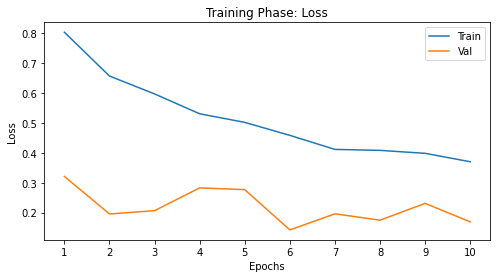

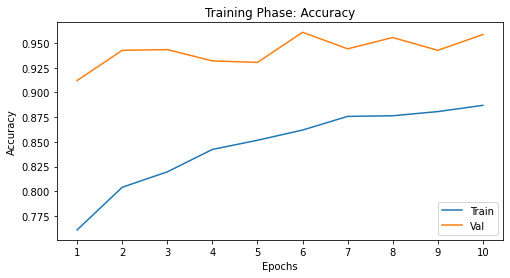

In [ ]:
x = range(1,len(train_losses)+1)

plt.figure(figsize=(8,4))
plt.title("Training Phase: Loss")
plt.plot(x,train_losses,label="Train")
plt.plot(x,val_losses,label="Val")
plt.xticks(range(1,len(x)+1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"{output_dir}/training_loss_"+indic+".png")
plt.show()

plt.figure(figsize=(8,4))
plt.title("Training Phase: Accuracy")
plt.plot(x,train_acc,label="Train")
plt.plot(x,val_acc,label="Val")
plt.xticks(range(1,len(x)+1))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"{output_dir}/training_acc_"+indic+".png")
plt.show()

## **Load the model**
----

You can load your best model to use in the inference phase. Note that ```pretrained``` is omitted and, by default, its value is ```False```.

In [ ]:
if opt =='1':
  net = models.resnet18()
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='2':
  net = models.resnet34()
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='3':
  net = models.densenet121()
  net.classifier = nn.Linear(num_ftrs, num_classes)
elif opt =='4':
  net = models.densenet161()
  net.classifier = nn.Linear(num_ftrs, num_classes)
elif opt =='5':
  net = models.googlenet(aux_logits=False)
  net.fc = nn.Linear(num_ftrs, num_classes)
elif opt =='6':
  net = models.inception_v3(aux_logits=False)
  net.fc = nn.Linear(num_ftrs, num_classes)
else:
  print("Invalid Option!")  
     
net = net.to(device)
net.load_state_dict(torch.load(best_model_full))
print("Best {} model loaded!".format(indic))

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Best Inception-v3 model loaded!


## **Inference phase**

----

In the inference phase, we measure the performance of our model based on the test dataset. 


In [ ]:
am_training = net.training
print('Am I training? ', am_training)
net.eval()
am_training = net.training
print('Am I training? ', am_training)
inference_loss = 0.0
inference_corrects = 0
phase = 'test'

infer_time_init = time.time()
with torch.no_grad():
  # Iterate over data: Begin
  for images, labels, paths in dataloaders[phase]: 
      images = Variable(images).to(device) # Send to GPU
      labels = Variable(labels).to(device) # Send to GPU

      outputs_infer = net(images)
      _, preds_infer = torch.max(outputs_infer,1)
      loss_infer = loss_function(outputs_infer, labels)

      inference_loss += loss_infer.item() * images.size(0)
      inference_corrects += torch.sum(preds_infer == labels.data)
  # Iterate over data: End

final_inference_loss = inference_loss / dataset_sizes[phase]
final_inference_acc = inference_corrects.double() / dataset_sizes[phase]

infer_time_end = time.time() - infer_time_init
print('\nTraining and inference in {:.0f}m {:.0f}s  OR  {:.0f}s'.format(
        (train_time_end + infer_time_end) // 60, 
        (train_time_end + infer_time_end) % 60,
         train_time_end + infer_time_end))

print('\nLoss of {}: {:.4f}'.format(indic, final_inference_loss))
print()
print('Accuracy of {}: {:.4f}'.format(indic, final_inference_acc))

Am I training?  True
Am I training?  False

Training and inference in 87m 4s  OR  5224s

Loss of Inception-v3: 0.4563

Accuracy of Inception-v3: 0.8807


In [ ]:
plt.ioff()